# taos2_drifters1: hydrology

In [1]:
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd

import pynsitu as pin
crs = pin.maps.crs

In [2]:
root_dir = "/Users/aponte/Current_Projects/taos/campagnes"

cp = pin.Campaign(os.path.join(root_dir,f"taos2/drifters1/taos2_drifters1.yaml"))

In [3]:
#dr = cp.load('drifters.nc', toframe=True)
#dr_ids = [u for u in cp if  "0-435" in u]
#colors = {i:c  for i, c in zip(dr_ids, plt.cm.Set2.colors[:len(dr_ids)] )}
# could also use: pin.get_cmap_colors(len(keys))

#ship = dict(ship_hydrophone=cp.load('ship_hydrophone', toframe=True),
#            ship_delphy=cp.load('ship_delphy', toframe=True),
#           )

def load_ctd(prefix):
    files = sorted(glob(os.path.join(cp["path_processed"], prefix, "*.nc")))

ctd = dict(delphy=cp.load('ctd_delphy*', toframe=True), 
           hydrophone=cp.load('ctd_hydrophone*', toframe=True)
          )

wind = cp.load("arome.nc")
#slvl = cp.load('sea_level.nc', toframe=True)

#dr.head()

In [4]:
# compute variable bounds
def tracers_global_bounds(v):
    _min, _max = [], []
    for u, c in ctd.items():
        for d, _df in c.items():
            #if in_tbounds(_df):
            if v in _df.columns:
                _min.append(_df[v].min())
                _max.append(_df[v].max())
    return min(_min), max(_max)

tracer_bounds = dict()
for v in ["temperature", "conductivity", "salinity", "DO_p", "DO_mgL", "Chl_ugL", "depth"]:
    tracer_bounds[v] = tracers_global_bounds(v)
    print(v, ": ", " / ".join([f"{b:.2f}" for b in tracer_bounds[v]]))

temperature :  15.10 / 17.80
conductivity :  42.18 / 43.97
salinity :  33.33 / 34.30
DO_p :  89.60 / 115.44
DO_mgL :  7.11 / 9.04
Chl_ugL :  0.16 / 6.37
depth :  0.25 / 33.75


---
## maps

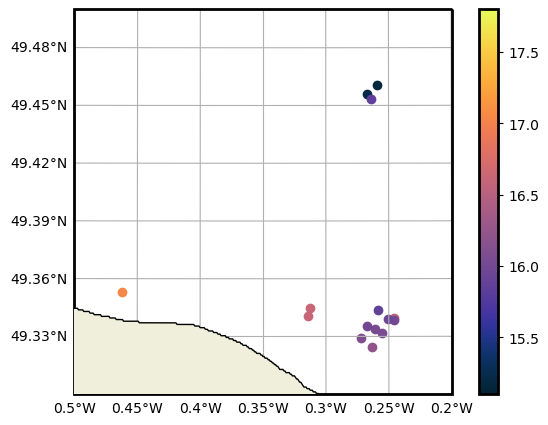

In [5]:
# global overview

bounds = [-.5, -.2, 49.3, 49.5]
v = "temperature"

figsize = (7,5)
fig, ax, cbar = cp.map(extent=bounds, rivers=False, figsize=figsize)
for u, c in ctd.items():
    for d, _df in c.items():
        if "_u" in d:
            pass
        elif "_c" in d or "_s" in d:
            _df = _df.mean()
        im = ax.scatter(_df.longitude, _df.latitude, c=_df[v],
                        transform=crs, vmin=tracer_bounds[v][0], vmax=tracer_bounds[v][1],
                        label=v, cmap=pin.thermal,
                        #**dkwargs
                       )
        #ax.text(_df.iloc[0].longitude+_txt_dl, _df.iloc[0].latitude+_txt_dl, 
        #        d, transform=crs, #**_txtkwargs,
        #       )


fig.colorbar(im)

### more temporally focused maps

In [6]:
# distinguish between different time periods
case=0
if case==0:
    # drifters2 - day0
    #t_bounds = ["2023-05-11 00:00:00", "2022-05-12 00:00:00"]
    case_label = "all"
    t_bounds = [cp["start"], cp["end"]]
    bounds = [-.5, -.21, 49.3, 49.48]
    map_figsize = (7,5)    
elif case==1:
    # drifters2 - day0
    #t_bounds = ["2023-05-11 00:00:00", "2022-05-12 00:00:00"]
    case_label = "day0"
    t_bounds = [cp[case_label].start.time, cp[case_label].end.time]
    bounds = [-.5, -.21, 49.3, 49.48]
    map_figsize = (7,5)
elif case==2:
    # drifters2 - day1
    # ...
    pass
#bounds = cp["bounds"]


def in_tbounds(df):
    if "time" not in df.columns:
        return True
    _df = df.loc[ ~np.isnat(df["time"]) ]
    _df = _df.reset_index().sort_values("time").set_index("time")
    return (not 
            _df.loc[ str(t_bounds[0]):str(t_bounds[1])]
            .empty
           )

# cancel effect of in_tbounds to use all available data:
#in_tbounds = lambda df: True

In [7]:
def scatter(v, labels=True, **kwargs):
    """ produce scatter plot """
    
    # compute global bounds
    vmin, vmax = _global_bounds(v)
    dkwargs = dict(vmin=vmin, vmax=vmax)
    dkwargs.update(**kwargs)
    
    fig, ax, cbar = cp.map(extent=bounds, rivers=False, figsize=map_figsize)
    
    _txt_dl = 0.001
    _txtkwargs = dict(fontsize=12)
    for u, c in ctd.items():
        for d, _df in c.items():
            if not in_tbounds(_df) or v not in _df.columns:
                continue
            if "_u" in d:
                #_df = _df.sw.resample("10s")
                im = ax.scatter(_df.longitude, _df.latitude, c=_df[v],
                                transform=crs, label=v,
                                **dkwargs
                               )
                if labels:
                    ax.text(_df.iloc[0].longitude+_txt_dl, _df.iloc[0].latitude+_txt_dl, 
                            d, transform=crs, **_txtkwargs,
                           )
            elif "_c" in d or "_s" in d:
                _df = _df.bfill().iloc[0]
                im = ax.scatter(_df.longitude, _df.latitude, c=_df[v],
                                transform=crs, label=v,
                                **dkwargs
                               )
                if labels:
                    ax.text(_df.longitude+_txt_dl, _df.latitude+_txt_dl, 
                            d.split("_")[-1], transform=crs, **_txtkwargs,
                           )
    ax.set_title(v)
    cbar = fig.colorbar(im)
    cbar.formatter.set_useOffset(False)
    
def _global_bounds(v):
    _min, _max = [], []
    for u, c in ctd.items():
        for d, _df in c.items():
            if v in _df.columns and in_tbounds(_df):
                _min.append(_df[v].min())
                _max.append(_df[v].max())
    return min(_min), max(_max)

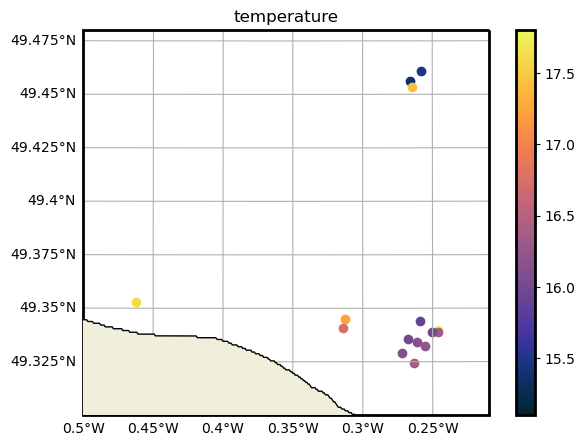

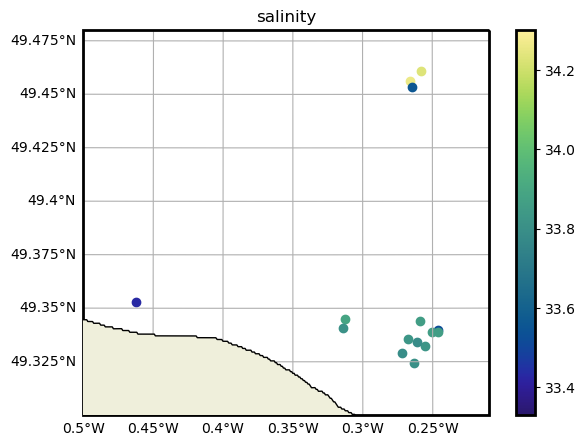

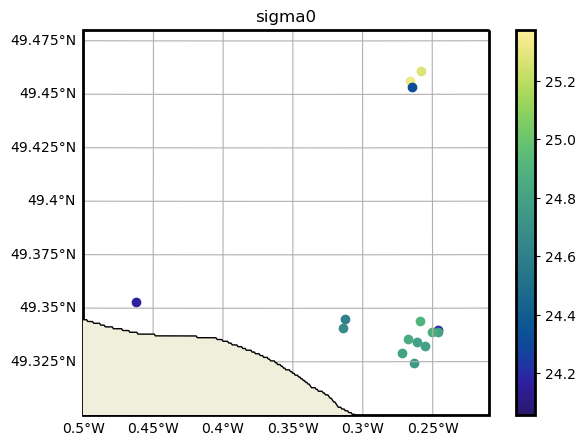

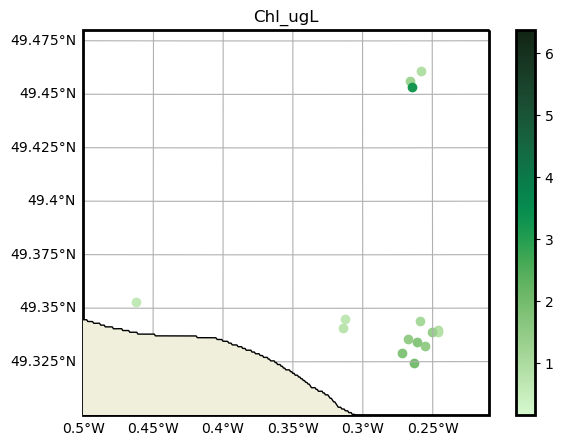

In [8]:
kw = dict(labels=False)
cbar = scatter("temperature", cmap=cm.thermal, **kw) # vmin=13.8, vmax=14.1
cbar = scatter("salinity", cmap=cm.haline, **kw) # vmin=31.5, vmax=33.5, 
cbar = scatter("sigma0", cmap=cm.haline, **kw) # vmin=24, 
cbar = scatter("Chl_ugL", cmap=cm.algae, **kw) #, vmax=5

### T/S plots

(15.0, 18.0)

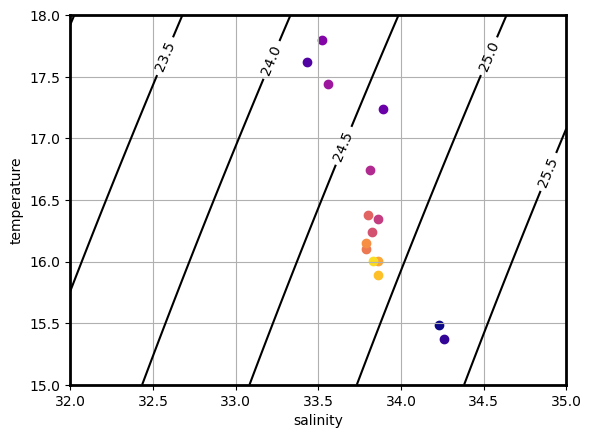

In [9]:
if case==0:
    # taos2_drifters0, all
    slim, tlim = (32., 35.), (15., 18.)
elif case==1:
    # taos2_drifters0, day0
    #slim, tlim = (32.5, 33.1), (14.0, 15.2) # drifters0 - day 1
    pass

D = {}
for u, c in ctd.items():
    for d, _df in c.items():
        if in_tbounds(_df):
            if "_c" in d:
                _df = _df.bfill().iloc[0]            
            D[u+"_"+d] = _df

fig, ax = pin.seawater.plot_ts(slim, tlim)
colors = pin.get_cmap_colors(len(D))
for d, c in zip(D, colors):
    _df = D[d]
    ax.scatter(_df.salinity, _df.temperature, c=c,) #, c=c label=d
#ax.legend()
ax.set_xlim(slim)
ax.set_ylim(tlim)

### concatenate data back and show histograms ... to be updated

In [10]:
#col_drop = ["time", "SA", "CT", "conductivity", "x", "y", "velocity_east", "velocity_north", "velocity", "pressure", "DO_p", "Chl_RFU"]
#df = pd.concat([df for d, df in D.items()], axis=0)
#df.drop(columns=col_drop, errors='ignore').hist(bins=50, figsize=(20,10));

### CTD cast

In [11]:
figsize=(5,5)

ncasts=0
for u, c in ctd.items():
    for d, _df in c.items():
        if in_tbounds(_df):
            if d[0]=="c":
                ncasts+=1

def plot_profiles(v, offset, units="", ax=None, legend=True):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=figsize)

    colors = pin.get_cmap_colors(ncasts)

    i=0
    for u, c in ctd.items():
        for d, df in c.items():
            if "_c" not in d or not in_tbounds(df) or v not in df.columns:
                continue
            off = offset*i
            ax.plot(df[v]+off, df.index, color=colors[i], lw=3, label=d) #u+"_"+d
            i+=1

    ax.grid()
    ax.set_title(v)
    ax.set_ylabel("z [m]")
    ax.set_xlabel(units)
    if legend:
        ax.legend(prop={'size': 7}, ncol=2)

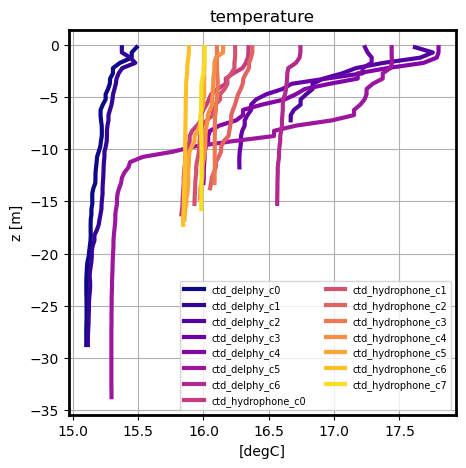

In [12]:
plot_profiles("temperature", 0., units="[degC]")

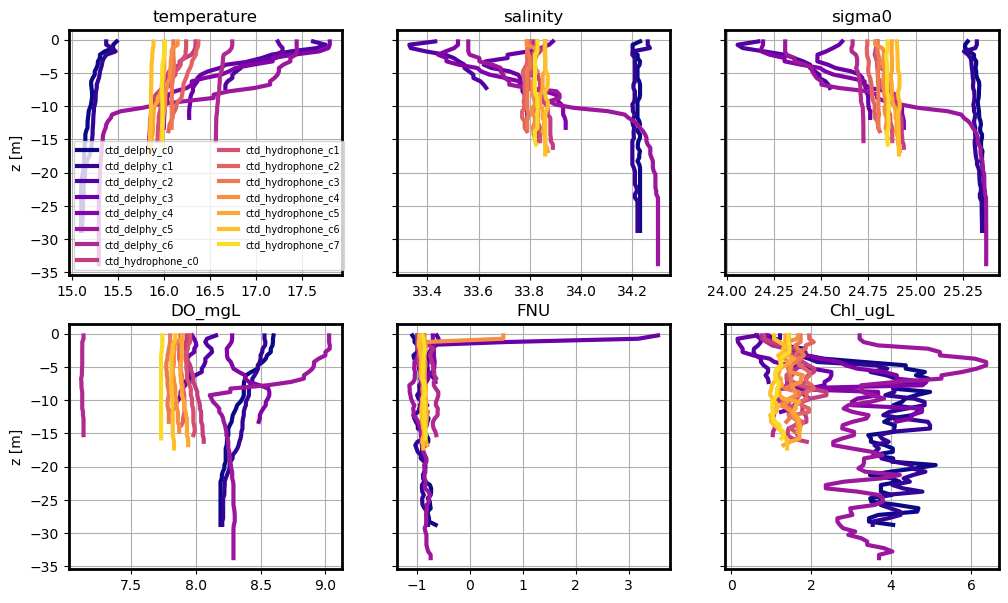

In [13]:
#V = ["temperature", "salinity", "sigma0", "DO_p", "DO_mgL", "FNU", "Chl_RFU",  "Chl_ugL"]
V = ["temperature", "salinity", "sigma0", "DO_mgL", "FNU",  "Chl_ugL"]


ncols=3
nrows = int(np.ceil(len(V)/ncols))

fig, axes = plt.subplots(nrows, ncols, 
                         figsize=(ncols*4, nrows*3.5),
                         #gridspec_kw=dict(hspace=0.1),
                        )

legend=True
i=0
for v, ax in zip(V, axes.flatten()[:len(V)]):
    plot_profiles(v, 0., units="", ax=ax, legend=legend)
    legend=False
    if i%ncols!=0:
        ax.set_ylabel("")
        ax.set_yticklabels("")
    i+=1

while i<nrows*ncols:
    axes.flatten()[i].axis('off')
    i+=1
    